In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)  # 输出均值 μ
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # 输出 log(σ²)
        
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mean(h), self.fc_logvar(h)  # μ, log(σ²)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # σ = exp(0.5 * log(σ²))
        eps = torch.randn_like(std)  # 噪声 ε ~ N(0, 1)
        return mu + eps * std  # z = μ + σ⊙ε
    
    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))  # 输出 [0,1] 之间的像素值
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))  # 展平输入
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar  # 返回重建数据、均值、log(σ²)

In [2]:
def loss_function(recon_x, x, mu, logvar):
    # 重建损失（Binary Cross Entropy）
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    # KL 散度（KL Divergence）
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD

In [3]:
import torch.optim as optim
from torchvision import datasets, transforms

# 数据加载
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

# 初始化模型和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 训练
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset):.4f}')

for epoch in range(1, 11):
    train(epoch)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:33<00:00, 293kB/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 120kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:12<00:00, 131kB/s] 


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.53MB/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Epoch 1, Loss: 164.0325
Epoch 2, Loss: 120.6414
Epoch 3, Loss: 114.2636
Epoch 4, Loss: 111.3151
Epoch 5, Loss: 109.5911
Epoch 6, Loss: 108.4685
Epoch 7, Loss: 107.5715
Epoch 8, Loss: 106.9941
Epoch 9, Loss: 106.4590
Epoch 10, Loss: 106.0594


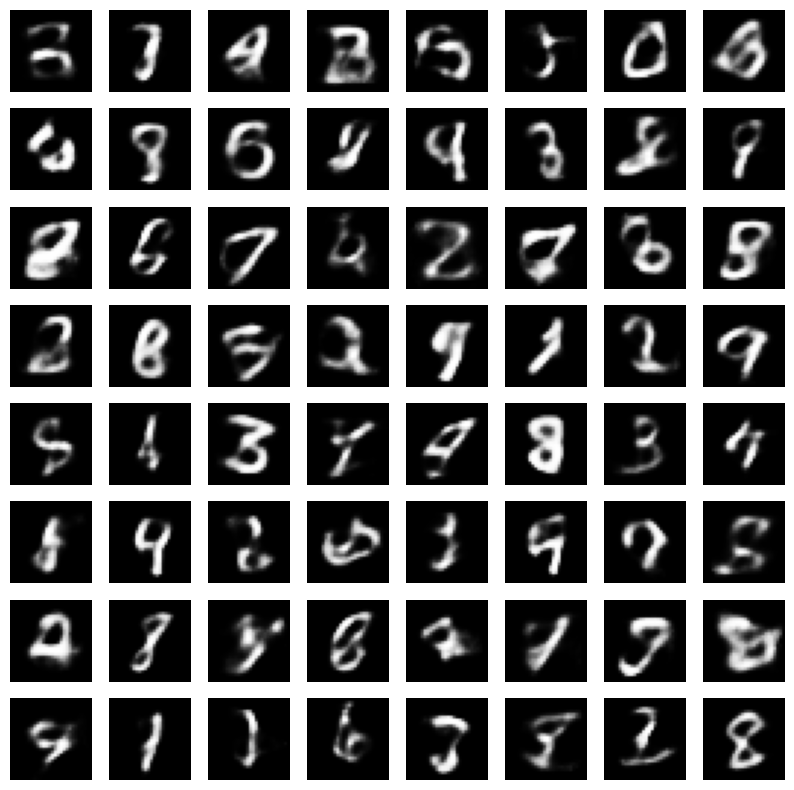

In [4]:
import matplotlib.pyplot as plt

# 从标准正态分布采样 z，并解码生成图像
with torch.no_grad():
    z = torch.randn(64, 20).to(device)  # 采样 64 个隐变量
    sample = model.decode(z).cpu()
    
    # 显示生成的图像
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(sample[i].view(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()